# Purpose

This notebook is to do analysis on the distribution of listening events across Freebase genres by looking at how many top genres is takes to cover a majority of listening events
## Loading Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import os
import swifter

## Preparing Data

In [2]:
artistToGenre = pd.read_parquet('../data/LastFM1bKidArtistToFreebaseGenre.gzip.parquet')
artistToGenre.head(5)

,Artist,Genre
0,MEGADETH,HEAVY METAL
1,DREAM THEATER,HEAVY METAL
2,AMON AMARTH,HEAVY METAL
3,ALTER BRIDGE,HEAVY METAL
4,LIMP BIZKIT,HEAVY METAL


### Ranking Genres from most listened to least

In [3]:
genreRanking = pd.read_parquet('../data/LastFM1bKidListeningEventsWithUsers', columns = ['Artist', 'User Id'])
genreRanking = genreRanking.groupby(['Artist']).agg(ArtistCount = ('User Id', 'count')).reset_index()
genreRanking.head(5)

,Artist,ArtistCount
0,! WWW.POLSKIE-MP3.TK ! AFRO KOLEKTYW,1
1,! WWW.POLSKIE-MP3.TK ! AKURAT,21
2,! WWW.POLSKIE-MP3.TK ! ALKATRAZ,43
3,! WWW.POLSKIE-MP3.TK ! BANACH & INDIOS BRAVOS,4
4,! WWW.POLSKIE-MP3.TK ! BRYGADA KRYZYS,11


In [4]:
genreRanking = genreRanking.merge(artistToGenre, on = 'Artist')
genreRanking.drop(columns = ['Artist'], inplace = True)
genreRanking.head(5)

,ArtistCount,Genre
0,571,ROCK
1,571,POP
2,571,DANCE
3,571,ALTERNATIVE ROCK
4,571,ALTERNATIVE


In [5]:
genreRanking = genreRanking.groupby(['Genre'], observed = True).agg(Count = ('ArtistCount', 'sum')).reset_index()
genreRanking.head(5)

,Genre,Count
0,ROCK,23655957
1,POP,15639176
2,DANCE,7144843
3,ALTERNATIVE ROCK,16203257
4,ALTERNATIVE,23240358


### User to Artist counts

In [6]:
userToArtistCounts = pd.read_parquet('../data/LastFM1bKidListeningEventsWithUsers', columns = ['Education Level', 'Age', 'Artist'])
userToArtistCounts.drop(columns = ['Partition'], inplace = True)
userToArtistCounts.head(5)

,Education Level,Age,Artist
0,HS,16,I BREAK HORSES
1,HS,16,TAYLOR SWIFT
2,HS,16,HIM
3,HS,16,AMARANTHE
4,HS,16,AMARANTHE


In [7]:
userToArtistCounts = userToArtistCounts.groupby(['Education Level', 'Age', 'Artist'], observed = True).agg(Count = ('Artist', 'count')).reset_index()
userToArtistCounts.head(5)

,Education Level,Age,Artist,Count
0,HS,15,I BREAK HORSES,5
1,HS,15,TAYLOR SWIFT,15038
2,HS,15,HIM,2180
3,HS,15,AMARANTHE,1792
4,HS,15,SERENITY,6


### Top X Genres to Listening Event Counts

In [8]:
calculations = pd.DataFrame({'Genres': itertools.accumulate(map(lambda x: [x], genreRanking['Genre'].to_list()))})
calculations.head(5)

,Genres
0,[ROCK]
1,"[ROCK, POP]"
2,"[ROCK, POP, DANCE]"
3,"[ROCK, POP, DANCE, ALTERNATIVE ROCK]"
4,"[ROCK, POP, DANCE, ALTERNATIVE ROCK, ALTERNATIVE]"


In [9]:
def CountListeningEventsIn(genres):
    result = artistToGenre[artistToGenre['Genre'].isin(genres)][['Artist']].drop_duplicates()
    result = userToArtistCounts.merge(result, on = 'Artist')
    result = result.groupby(['Education Level', 'Age'], observed = True).agg(Total = ('Count', 'sum'))
    result = result.rename(columns = {'Total': len(genres)})
    
    return result

data = calculations['Genres'].swifter.allow_dask_on_strings(enable = True).apply(CountListeningEventsIn)
data = pd.concat(data.to_list(), axis = 1)
data

Dask Apply:   0%|          | 0/32 [00:00<?, ?it/s]

1         2         3         4         5     \
Education Level Age                                                     
HS              15    2776222   3357414   3472254   3514571   3578113   
                16    6202368   7454964   7659308   7788922   7989026   
                17   12523540  14963369  15387115  15673125  16113751   
GS              6      178373    212541    220231    222632    233379   
                7       47727     55672     58912     59928     62772   
                8      110588    152810    154378    158269    162009   
                9        8038      9464      9671      9682     10558   
                10     119162    133660    135704    138088    144749   
                11     123284    150693    156371    157598    163118   
MS              12      77101    100330    107389    107684    116171   
                13     352405    430953    441766    449352    464822   
                14    1002469   1246273   1306206   1329486   1353461   

                         6         7         8         9         10    ...  \
Education Level Age                                                    ...   
HS              15    3615984   3667646   3668544   3682561   3779287  ...   
                16    8064366   8173091   8178099   8231381   8482088  ...   
                17   16276587  16480005  16485908  16592452  17122643  ...   
GS              6      234391    244856    245106    247054    254930  ...   
                7       66449     69896     69906     71571     76876  ...   
                8      163700    164001    164048    164763    165954  ...   
                9       10607     10621     10628     12356     14761  ...   
                10     146330    148068    148126    148696    150300  ...   
                11     166004    166574    166606    167622    170480  ...   
MS              12     119873    122167    122167    129102    142280  ...   
                13     468188    472446    472578    476195    489557  ...   
                14    1365009   1386046   1386448   1393196   1433808  ...   

                         1321      1322      1323      1324      1325  \
Education Level Age                                                     
HS              15    4194050   4194050   4194050   4194050   4194050   
                16    9527076   9527076   9527076   9527076   9527076   
                17   19257063  19257063  19257063  19257064  19257064   
GS              6      289917    289917    289917    289917    289917   
                7       88300     88300     88300     88300     88300   
                8      173179    173179    173179    173179    173179   
                9       16314     16314     16314     16314     16314   
                10     160702    160702    160702    160702    160702   
                11     190504    190504    190504    190504    190504   
MS              12     161832    161832    161832    161832    161832   
                13     544006    544006    544006    544006    544006   
                14    1609357   1609357   1609357   1609357   1609357   

                         1326      1327      1328      1329      1330  
Education Level Age                                                    
HS              15    4194050   4194050   4194050   4194050   4194050  
                16    9527076   9527076   9527076   9527076   9527076  
                17   19257069  19257082  19257082  19257082  19257082  
GS              6      289917    289917    289917    289917    289917  
                7       88300     88300     88300     88300     88300  
                8      173179    173179    173179    173179    173179  
                9       16314     16314     16314     16314     16314  
                10     160702    160702    160702    160702    160702  
                11     190504    190504    190504    190504    190504  
MS              12     161832    161832    161832    161832    161832  
                13    

## Graphs 
### by Age

In [10]:
graphData = data.fillna(0).reset_index().drop(columns = 'Education Level').set_index('Age').unstack().reset_index().rename(columns = {'level_0': 'Top X', 0: 'Listening Event Count'})
temp = graphData.groupby(['Age']).agg(Total = ('Listening Event Count', 'max'))
graphData = graphData.merge(temp, on = 'Age')
graphData['% of Listening Events'] = graphData['Listening Event Count'] / graphData['Total']
graphData

,Top X,Age,Listening Event Count,Total,% of Listening Events
0,1,15,2776222,4194050,0.661943
1,2,15,3357414,4194050,0.800518
2,3,15,3472254,4194050,0.827900
3,4,15,3514571,4194050,0.837990
4,5,15,3578113,4194050,0.853140
...,...,...,...,...,...
15955,1326,14,1609357,1609357,1.000000
15956,1327,14,1609357,1609357,1.000000
15957,1328,14,1609357,1609357,1.000000
15958,1329,14,1609357,1609357,1.000000


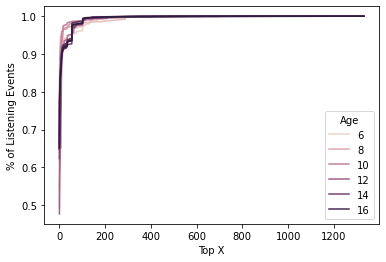

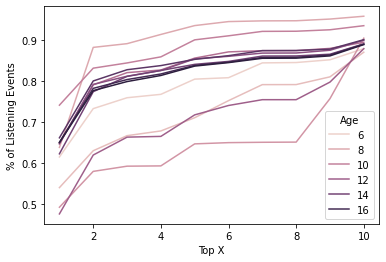

In [11]:
sns.lineplot(data = graphData, x = 'Top X', hue = 'Age', y = '% of Listening Events')
plt.show()
sns.lineplot(data = graphData[graphData['Top X'] <= 10], x = 'Top X', hue = 'Age', y = '% of Listening Events');

### by Education Level

In [12]:
graphData = data.fillna(0).reset_index().drop(columns = 'Age').groupby('Education Level').sum().unstack().reset_index().rename(columns = {'level_0': 'Top X', 0: 'Listening Event Count'})
temp = graphData.groupby(['Education Level']).agg(Total = ('Listening Event Count', 'max'))
graphData = graphData.merge(temp, on = 'Education Level')
graphData['% of Listening Events'] = graphData['Listening Event Count'] / graphData['Total']
graphData

,Top X,Education Level,Listening Event Count,Total,% of Listening Events
0,1,GS,587172,918916,0.638983
1,2,GS,714840,918916,0.777917
2,3,GS,735267,918916,0.800146
3,4,GS,746197,918916,0.812040
4,5,GS,776585,918916,0.845110
...,...,...,...,...,...
3985,1326,HS,32978195,32978208,1.000000
3986,1327,HS,32978208,32978208,1.000000
3987,1328,HS,32978208,32978208,1.000000
3988,1329,HS,32978208,32978208,1.000000


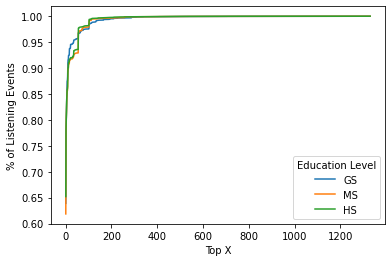

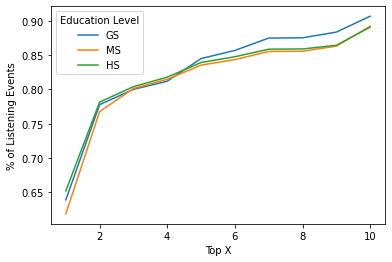

In [13]:
sns.lineplot(data = graphData, x = 'Top X', hue = 'Education Level', y = '% of Listening Events')
plt.show()
sns.lineplot(data = graphData[graphData['Top X'] <= 10], x = 'Top X', hue = 'Education Level', y = '% of Listening Events');